In [1]:
# Standard python helper libraries.
import os, sys, re, json, time, wget, csv, string, time, random
import itertools, collections

# NumPy
import numpy as np

# NLTK for NLP utils
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from keras import backend as K
from keras.models import Sequential
from keras.layers import GaussianNoise, Dropout, Dense, Embedding, MaxPool1D, GlobalMaxPool1D, Conv1D, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from pymagnitude import *

[nltk_data] Downloading package punkt to /home/renzeer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renzeer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Categorical Classifier for Phenotypes using a Convolutional Neural Network

In this notebook, we will be building a model for classifying a sentence from an EHR note for the presence of phenotypes. The model will be trained using a convoultional neural network (CNN). 

## Word Embedding

The first step is to load in our word embedding, which is trained on text from Wikipedia, Pubmed, and Pubmed Central. We load our word embedding through a tool called Magnitude. A full exploration of the word embedding and Magnitude can be found in the Introduction notebook.

In [2]:
med_vectors = Magnitude("data/wikipedia-pubmed-and-PMC-w2v.magnitude", pad_to_length=30)

## Text Preprocessing

In [3]:
ehr_notes = []
with open('data/ehr_samples.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:     
        if int(row['SpecialtyID']) in [39, 6, 16, 37, 11, 12, 29, 26, 7, 21, 19, 10, 2, 18]:
            continue
        else:
            ehr_notes.append([row['Specialty'], row['Note']])

print(ehr_notes[0])
print(ehr_notes[2])

['Bariatrics', 'PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two blocks or five flights of stairs.  Difficulty with snoring.  He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling.  He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago.  ,SOCIAL HISTORY:, He is currently single.  He has about ten drinks a year.  He had smoked significantly up until several months ago.  He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes.  Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:,  He is allergic to Penicillin.,MISCELLANEOUS/EATING HIS

## Natural Langauge Processing

In [4]:
ehr_sentences = []
for record in ehr_notes:
    sent_text = nltk.sent_tokenize(record[1])
    for sent in sent_text:
        tokens = word_tokenize(sent)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]

#         # stem words
#         porter = PorterStemmer()
#         tokens = [porter.stem(word) for word in tokens]

        # remove blanks
        tokens = [w for w in tokens if w != '']

        ehr_sentences.append([record[0], ' '.join(tokens)])

random.Random(4).shuffle(ehr_sentences)

print(ehr_sentences[0])
print(ehr_sentences[1])

['Cardiovascular', 'return clinic 4 weeks5']
['Orthopedic', 'biceps tendon nonsubluxable']


## Defining our Training and Test Data

Before we can start building our neural networks, we first have to define our datasets. Specifically, we have to break up our EHR data so that we have records that we can train on and records that are exclusively used to test on. Maintaining a separate set for testing ensures we avoid overfitting our data.

We will use some built-in functions provided by Magnitude that helps encode our classes/categories. We then partition our data into our train and test sets. For each set we have both data and labels. Initially, we will be making these partitions small to make iterating through model development much quicker. However, once the models are developed, we will expand our datasets to include all of our data. To ensure we defined our data correctly, we can print a few lines from the two sets.

In [5]:
len(ehr_sentences)

70941

In [6]:
add_intent, intent_to_int, int_to_intent = MagnitudeUtils.class_encoding()

x_train = [ehr_sent[1].split(' ') for ehr_sent in ehr_sentences[:60000]]
x_test = [ehr_sent[1].split(' ') for ehr_sent in ehr_sentences[60001:]]

y_train = [add_intent(ehr_sent[0]) for ehr_sent in ehr_sentences[:60000]]
y_test = [add_intent(ehr_sent[0]) for ehr_sent in ehr_sentences[60001:]]

y_train = list(np.array(y_train).reshape(len(y_train)))
y_test = list(np.array(y_test).reshape(len(y_test)))

num_training = len(x_train)
num_test = len(x_test)
num_outputs = int(max(max(y_train), max(y_test))) + 1

print(int_to_intent(0))

print("First line of train/test data:")
print("\t", x_train[0])
print("\t", y_train[0], int_to_intent(y_train[0]))
print("\t", x_test[0])
print("\t", y_test[0], int_to_intent(y_test[0]))
print("Second line of train/test data:")
print("\t", x_train[1])
print("\t", y_train[1], int_to_intent(y_train[1]))
print("\t", x_test[1])
print("\t", y_test[1], int_to_intent(y_test[1]))

Cardiovascular
First line of train/test data:
	 ['return', 'clinic', '4', 'weeks5']
	 0 Cardiovascular
	 ['smokes', 'one', 'pack', 'per', 'day']
	 0 Cardiovascular
Second line of train/test data:
	 ['biceps', 'tendon', 'nonsubluxable']
	 1 Orthopedic
	 ['denies', 'illicit', 'drug', 'use', 'family', 'history', 'parents', 'died', 'myocardial', 'infarctions']
	 7 Psychiatry


## Defining Custom Callback Function

In [7]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Defining Model

In [8]:
MAX_WORDS = 30 # The maximum number of words the sequence model will consider
STD_DEV = 0.01 # Deviation of noise for Gaussian Noise applied to the embeddings
DROPOUT_RATIO = .5 # The ratio to dropout
BATCH_SIZE = 100 # The number of examples per train/validation step
EPOCHS = 100 # The number of times to repeat through all of the training data
LEARNING_RATE = .01 # The learning rate for the optimizer
HIDDEN_UNITS = 100

model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, med_vectors.dim)))
model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 30, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                5226      
Total params: 246,026
Trainable params: 246,026
Non-trainable params: 0
_________________________________________________________________


## Training Batches and Epochs

In [9]:
training_batches = MagnitudeUtils.batchify(x_train, y_train, BATCH_SIZE) # Split the training data into batches
num_batches_per_epoch_train = int(np.ceil(num_training/float(BATCH_SIZE)))
test_batches = MagnitudeUtils.batchify(x_test, y_test, BATCH_SIZE)  # Split the test data into batches
num_batches_per_epoch_test = int(np.ceil(num_test/float(BATCH_SIZE)))


# Generates batches of the transformed training data
train_batch_generator = (
  (
    med_vectors.query(x_train_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_train_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_train_batch, y_train_batch in training_batches
)

# Generates batches of the transformed test data
test_batch_generator = (
  (
    med_vectors.query(x_test_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_test_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_test_batch, y_test_batch in test_batches
)

# Start training
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = test_batch_generator,
    validation_steps = num_batches_per_epoch_test,
    epochs = EPOCHS,
)

Epoch 1/100
600/600 [==============================] - 2269s 4s/step - loss: 0.1264 - acc: 0.9630 - f1: 0.1439 - val_loss: 0.1142 - val_acc: 0.9644 - val_f1: 0.2085
Epoch 2/100
600/600 [==============================] - 123s 204ms/step - loss: 0.1134 - acc: 0.9647 - f1: 0.2568 - val_loss: 0.1080 - val_acc: 0.9658 - val_f1: 0.3016
Epoch 3/100
600/600 [==============================] - 124s 207ms/step - loss: 0.1095 - acc: 0.9655 - f1: 0.2945 - val_loss: 0.1061 - val_acc: 0.9661 - val_f1: 0.3281
Epoch 4/100
600/600 [==============================] - 124s 206ms/step - loss: 0.1072 - acc: 0.9659 - f1: 0.3152 - val_loss: 0.1045 - val_acc: 0.9663 - val_f1: 0.3519
Epoch 5/100
600/600 [==============================] - 124s 206ms/step - loss: 0.1054 - acc: 0.9663 - f1: 0.3310 - val_loss: 0.1030 - val_acc: 0.9666 - val_f1: 0.3651
Epoch 6/100
600/600 [==============================] - 126s 211ms/step - loss: 0.1038 - acc: 0.9666 - f1: 0.3450 - val_loss: 0.1021 - val_acc: 0.9667 - val_f1: 0.3681


Epoch 50/100
600/600 [==============================] - 121s 202ms/step - loss: 0.0741 - acc: 0.9736 - f1: 0.5609 - val_loss: 0.1020 - val_acc: 0.9660 - val_f1: 0.4347
Epoch 51/100
600/600 [==============================] - 122s 203ms/step - loss: 0.0737 - acc: 0.9737 - f1: 0.5651 - val_loss: 0.1031 - val_acc: 0.9659 - val_f1: 0.4326
Epoch 52/100
600/600 [==============================] - 122s 203ms/step - loss: 0.0735 - acc: 0.9738 - f1: 0.5668 - val_loss: 0.1022 - val_acc: 0.9657 - val_f1: 0.4302
Epoch 53/100
600/600 [==============================] - 124s 206ms/step - loss: 0.0727 - acc: 0.9739 - f1: 0.5706 - val_loss: 0.1032 - val_acc: 0.9656 - val_f1: 0.4326
Epoch 55/100
600/600 [==============================] - 119s 198ms/step - loss: 0.0720 - acc: 0.9741 - f1: 0.5753 - val_loss: 0.1032 - val_acc: 0.9656 - val_f1: 0.4300
Epoch 56/100
600/600 [==============================] - 121s 202ms/step - loss: 0.0718 - acc: 0.9742 - f1: 0.5765 - val_loss: 0.1044 - val_acc: 0.9654 - val_f1:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 119s 199ms/step - loss: 0.0700 - acc: 0.9746 - f1: 0.5870 - val_loss: 0.1073 - val_acc: 0.9651 - val_f1: 0.4300
Epoch 62/100
600/600 [==============================] - 120s 200ms/step - loss: 0.0699 - acc: 0.9747 - f1: 0.5882 - val_loss: 0.1069 - val_acc: 0.9652 - val_f1: 0.4307
Epoch 63/100
600/600 [==============================] - 98s 164ms/step - loss: 0.0691 - acc: 0.9749 - f1: 0.5938 - val_loss: 0.1070 - val_acc: 0.9649 - val_f1: 0.4224
Epoch 64/100
600/600 [==============================] - 69s 115ms/step - loss: 0.0689 - acc: 0.9749 - f1: 0.5937 - val_loss: 0.1076 - val_acc: 0.9651 - val_f1: 0.4317
Epoch 65/100
600/600 [==============================] - 70s 116ms/step - loss: 0.0687 - acc: 0.9750 - f1: 0.5960 - val_loss: 0.1081 - val_acc: 0.9650 - val_f1: 0.4317
Epoch 66/100
280/600 [=============>................] - ETA: 35s - loss: 0.0683 - acc: 0.9750 - f1: 0.5978

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 70s 116ms/step - loss: 0.0674 - acc: 0.9753 - f1: 0.6037 - val_loss: 0.1103 - val_acc: 0.9647 - val_f1: 0.4303
Epoch 70/100
600/600 [==============================] - 71s 118ms/step - loss: 0.0673 - acc: 0.9754 - f1: 0.6055 - val_loss: 0.1105 - val_acc: 0.9645 - val_f1: 0.4302
Epoch 71/100
600/600 [==============================] - 69s 115ms/step - loss: 0.0670 - acc: 0.9754 - f1: 0.6069 - val_loss: 0.1114 - val_acc: 0.9645 - val_f1: 0.4292
Epoch 72/100
600/600 [==============================] - 69s 116ms/step - loss: 0.0666 - acc: 0.9755 - f1: 0.6086 - val_loss: 0.1128 - val_acc: 0.9644 - val_f1: 0.4303
Epoch 73/100
600/600 [==============================] - 70s 117ms/step - loss: 0.0661 - acc: 0.9757 - f1: 0.6120 - val_loss: 0.1105 - val_acc: 0.9645 - val_f1: 0.4267
Epoch 74/100
145/600 [======>.......................] - ETA: 49s - loss: 0.0669 - acc: 0.9756 - f1: 0.6110

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 69s 115ms/step - loss: 0.0655 - acc: 0.9758 - f1: 0.6152 - val_loss: 0.1115 - val_acc: 0.9645 - val_f1: 0.4291
Epoch 78/100
600/600 [==============================] - 70s 116ms/step - loss: 0.0650 - acc: 0.9760 - f1: 0.6200 - val_loss: 0.1127 - val_acc: 0.9640 - val_f1: 0.4227
Epoch 79/100
600/600 [==============================] - 70s 117ms/step - loss: 0.0649 - acc: 0.9761 - f1: 0.6207 - val_loss: 0.1131 - val_acc: 0.9640 - val_f1: 0.4255
Epoch 80/100
600/600 [==============================] - 69s 115ms/step - loss: 0.0641 - acc: 0.9762 - f1: 0.6244 - val_loss: 0.1152 - val_acc: 0.9638 - val_f1: 0.4254
Epoch 81/100
600/600 [==============================] - 69s 116ms/step - loss: 0.0642 - acc: 0.9762 - f1: 0.6239 - val_loss: 0.1135 - val_acc: 0.9641 - val_f1: 0.4248
Epoch 82/100
140/600 [======>.......................] - ETA: 48s - loss: 0.0648 - acc: 0.9760 - f1: 0.6210

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 71s 118ms/step - loss: 0.0631 - acc: 0.9765 - f1: 0.6301 - val_loss: 0.1154 - val_acc: 0.9637 - val_f1: 0.4241
Epoch 86/100
600/600 [==============================] - 71s 119ms/step - loss: 0.0631 - acc: 0.9765 - f1: 0.6308 - val_loss: 0.1141 - val_acc: 0.9640 - val_f1: 0.4271
Epoch 87/100
600/600 [==============================] - 68s 114ms/step - loss: 0.0633 - acc: 0.9765 - f1: 0.6296 - val_loss: 0.1156 - val_acc: 0.9638 - val_f1: 0.4241
Epoch 88/100
600/600 [==============================] - 70s 117ms/step - loss: 0.0628 - acc: 0.9766 - f1: 0.6326 - val_loss: 0.1179 - val_acc: 0.9635 - val_f1: 0.4238
Epoch 89/100
600/600 [==============================] - 70s 116ms/step - loss: 0.0627 - acc: 0.9766 - f1: 0.6330 - val_loss: 0.1160 - val_acc: 0.9635 - val_f1: 0.4224
Epoch 90/100
600/600 [==============================] - 69s 115ms/step - loss: 0.0622 - acc: 0.9768 - f1: 0.6368 - val_loss: 0.1174 - val_acc: 0.9633 - val_f1: 0.4175
Epoch 91/10

## Results

In [10]:
print("Results after training for %d epochs:" % (EPOCHS,))

train_metrics = model.evaluate_generator(
    generator = train_batch_generator,
    steps = num_batches_per_epoch_train,
)

print("loss: %.4f - categorical_accuracy: %.4f - f1: %.4f" % tuple(train_metrics))

val_metrics = model.evaluate_generator(
    generator = test_batch_generator,
    steps = num_batches_per_epoch_test,
)

print("val_loss: %.4f - val_categorical_accuracy: %.4f - f1: %.4f" % tuple(val_metrics))

Results after training for 100 epochs:
loss: 0.0551 - categorical_accuracy: 0.9785 - f1: 0.6698
val_loss: 0.1206 - val_categorical_accuracy: 0.9630 - f1: 0.4164


## Conclusion

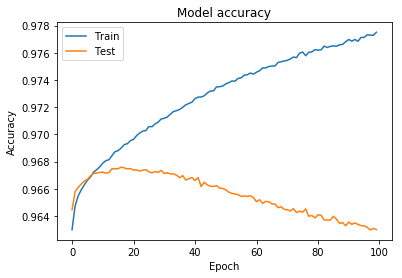

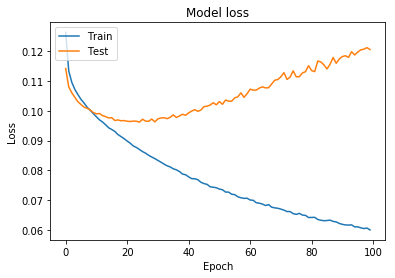

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(med_vectors.query(x_test)), axis=1)
class_labels = [int_to_intent(y) for y in set(y_test)] 
report = classification_report(y_test, y_pred, target_names=class_labels)
print(class_labels)
print(confusion_matrix(y_test, y_pred))
print(report)

['Cardiovascular', 'Orthopedic', 'Otolaryngology', 'Podiatry', 'Bariatrics', 'Neurology', 'Pediatrics', 'Psychiatry', 'Gastroenterology', 'Gynecology', 'Radiology', 'Oncology', 'Dentistry', 'Urology', 'Neurosurgery', 'Nephrology', 'Chiropractic', 'Endocrinology', 'Rehab', 'Ophthalmology', 'Dermatology', 'Sleep', 'Rheumatology', 'Pathology', 'Allergy', 'Speech']
[[1071   80   39    0    3   54   48   15  108   28   93   32    1   24
     7   43    0    7    0    4    1    3    4   10    2    0]
 [  71 1143   14   67    1  124   10    8   37   18   46    9    5   19
   145    4   34    4   15    9    6    1    2    0    0    0]
 [  25   28  151    0    1   22   30    1   18    6    3    6    4   11
     2    1    0   14    0   17    1    0    1    0    0    0]
 [  11  151    0   18    0    2    0    0    1    6    2    1    1    2
     0    0    2    0    0    0    2    0    1    0    0    0]
 [   5    8    4    1    8    5    3    4   15    1    0    3    0    1
     0    1    0    1   

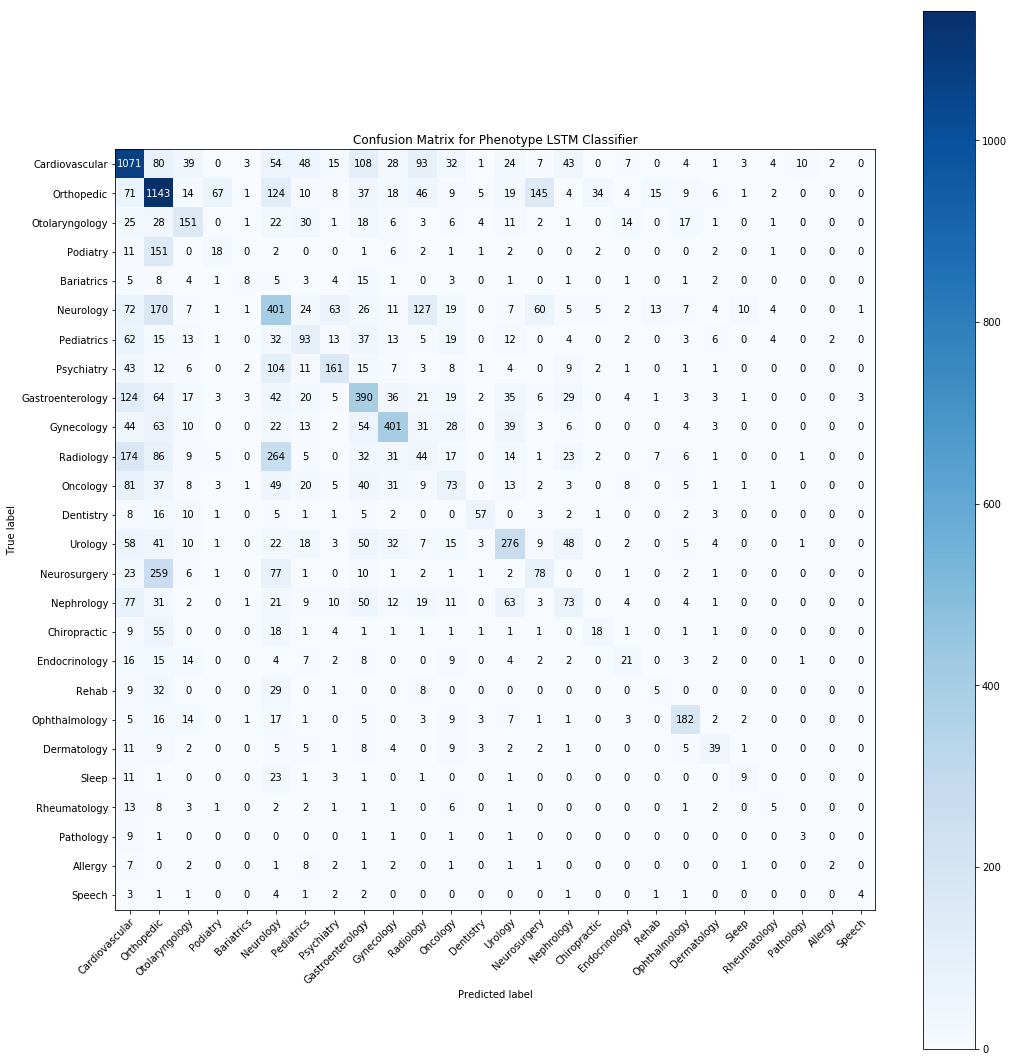

In [15]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [int_to_intent(y_class) for y_class in unique_labels(y_test, y_pred)]

    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_labels
                      , title='Confusion Matrix for Phenotype LSTM Classifier')

In [21]:
correct = 0
for i, y in enumerate(y_pred):
    if y == y_test[i]:
        correct += 1

correct / len(y_pred)

0.4319926873857404